# Recommenders on ML-1m

## Setup

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import math

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

## Data

In [ ]:
!wget -q --show-progress http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

ml-1m.zip           100%[===================>]   5.64M  27.5MB/s    in 0.2s    
Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
df_ratings = pd.read_csv("./ml-1m/ratings.dat",
                         sep="::",
                         header=None,
                         engine='python',
                         names=["UserID", "MovieID", "Rating", "Timestamp"])
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
df_movies = pd.read_csv("./ml-1m/movies.dat",
                         sep="::",
                         header=None,
                         engine='python',
                         names=["MovieID", "Title", "Genres"])
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_users = pd.read_csv("./ml-1m/users.dat",
                         sep="::",
                         header=None,
                         engine='python',
                         names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
df_ratings.shape, df_movies.shape, df_users.shape

((1000209, 4), (3883, 3), (6040, 5))

In [ ]:
# merge
df_ratings_movies = pd.merge(df_ratings, df_movies, on='MovieID')
df = pd.merge(df_ratings_movies, df_users, on="UserID")
df_raw = df.copy()

# drop columns
df = df.drop(['Timestamp','Genres','Gender','Age','Occupation','Zip-code'], axis=1)

## Recommend Popular (most-watched) Movies

In [ ]:
# Recommend 5 most seen movies
def recommend_movie(n):
    movie_rank = df['MovieID'].value_counts()[:n]
    recommend_movies = df.loc[movie_rank.index]
    recommend = recommend_movies['Title']
    return recommend

In [ ]:
recommend_movie(5)

2858                Muppet Treasure Island (1996)
260                            Dragonheart (1996)
1196    Close Encounters of the Third Kind (1977)
1210                   Breakfast Club, The (1985)
480                          Shanghai Noon (2000)
Name: Title, dtype: object

Evaluate

In [ ]:
# Split train, test set
x_train, x_test = train_test_split(df, test_size=0.05)

# Recommend n most popular movies on a dataset
def popular_movie(dataset, n):
    movie_rank = dataset['MovieID'].value_counts()[:n]
    popular_movies = dataset.iloc[movie_rank.index]
    return popular_movies

# Calculate hitrate@K
def hitrate(K):
    raw_ranking = popular_movie(df, K)
    pred_ranking = popular_movie(x_test, K)
    return raw_ranking['MovieID'].isin(pred_ranking['MovieID']).value_counts(normalize=True)[True]

hitrate(100)

0.07

## Recommend Popular (high-rated) Movies

In [ ]:
# Recommend 5 movies with high ratings
def recommend_movie2(n):
    movie_sort = movie_mean.sort_values(ascending=False)[:n]
    recommend_movies = df.loc[movie_sort.index]
    recommendation = recommend_movies['Title']
    return recommendation

movie_mean = df.groupby(['MovieID'])['Rating'].mean()
recommend_movie2(5)

MovieID
3382                        Sneakers (1992)
3172                              Pi (1998)
3607                        Candyman (1992)
3656                       Junk Mail (1997)
3280    Teenage Mutant Ninja Turtles (1990)
Name: Title, dtype: object

Evaluate

In [ ]:
# Split train, test set
x_train, x_test = train_test_split(df, test_size=0.05)

# dRecommend n most popular movies on a dataset
def popular_movie(dataset, n):
    movie_rank = dataset['MovieID'].value_counts()[:n]
    popular_movies = dataset.iloc[movie_rank.index]
    return popular_movies

# Calculate hitrate@K
def hitrate(K):
    raw_ranking = popular_movie(df, K)
    pred_ranking = popular_movie(x_test, K)
    return raw_ranking['MovieID'].isin(pred_ranking['MovieID']).value_counts(normalize=True)[True]

hitrate(100)

0.1

In [ ]:
# Accuracy calculation
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

rmse = []
for user in set(df.index):
    y_true = df.loc[user]['Rating']
    y_pred = movie_mean[df.loc[user]['MovieID']]
    accuracy = RMSE(y_true, y_pred)
    rmse.append(accuracy)
print(np.mean(rmse))

In [ ]:
# Split train, test set
x = df.copy()
y = df['UserID']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.05,stratify=y)

# Accuracy calculation
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# Calculate RMSE by model
def score(model):
    id_pairs = zip(x_test['UserID'], x_test['MovieID'])
    y_pred = np.array([model(user,movie) for (user,movie) in id_pairs])
    y_true = np.array(x_test['Rating'])
    return RMSE(y_true, y_pred)

# Get full matrix with training df
rating_matrix = x_train.pivot(index='UserID', columns='MovieID', values='Rating')

# The default model for calculating forecasts by the overall mean
def best_seller(user_id, movie_id):
    try:
        rating = train_mean[movie_id]
    except:
        rating = 3.0
    return rating

train_mean = x_train.groupby(['MovieID'])['Rating'].mean()
score(best_seller)

## Recommend Genre-wise Popular Movies

In [ ]:
df = df_raw.copy()

Data preprocessing (extracting data only from users who have watched more than 50 movies)

In [ ]:
count = df['UserID'].value_counts()
count_index = count[count > 50]
data_pre = df[df['UserID'].isin(count_index)]
data_pre.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
3025,53,1193,5,977946400,One Flew Over the Cuckoo's Nest (1975),Drama,M,25,0,96931
3026,53,661,5,977979726,James and the Giant Peach (1996),Animation|Children's|Musical,M,25,0,96931
3027,53,914,5,977979589,My Fair Lady (1964),Musical|Romance,M,25,0,96931
3028,53,2355,5,977948959,"Bug's Life, A (1998)",Animation|Children's|Comedy,M,25,0,96931
3029,53,594,5,977979520,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,M,25,0,96931


In [ ]:
x_train, x_test = train_test_split(data_pre, test_size=0.05)

Top-10 most-watched movies for the given genre

In [ ]:
def genre_pop(dataset, genre, n):
    dataset_genres = dataset['Genres'].str.get_dummies("|")
    select_genre = dataset_genres[dataset_genres[genre]==1]
    genre_popmovie = dataset.loc[select_genre.index]
    genre_popmovie = genre_popmovie.reset_index()
    genre_popmovie_rank = genre_popmovie['MovieID'].value_counts()[:n]
    recomm_movie = genre_popmovie.loc[genre_popmovie_rank.index]
    return recomm_movie

genre_pop(x_train, 'Comedy', 10)

,index,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
2858,27923,411,2375,2,978453240,"Money Pit, The (1986)",Comedy,F,45,1,43214
1580,881266,873,3076,3,975438076,Irma la Douce (1963),Comedy,M,56,6,19027
1270,14433,235,497,4,977100643,Much Ado About Nothing (1993),Comedy|Romance,M,25,0,98153
1197,457671,78,156,2,978570873,Blue in the Face (1995),Comedy,F,45,1,98029
2396,65764,934,322,4,975184082,Swimming with Sharks (1995),Comedy|Drama,F,35,7,97401
1265,918127,405,1304,4,976388574,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western,M,56,1,13077
2997,20875,317,2000,4,976460939,Lethal Weapon (1987),Action|Comedy|Crime|Drama,M,35,7,38555
356,792823,263,2791,3,976652161,Airplane! (1980),Comedy,F,25,7,22304
1,19274,301,1377,4,976504613,Batman Returns (1992),Action|Adventure|Comedy|Crime,M,18,4,61820
2791,86609,1169,153,2,974861777,Batman Forever (1995),Action|Adventure|Comedy|Crime,M,25,20,94402


User's genre ranking in the training set

In [ ]:
def user_genre(dataset, userid):
    user_data = dataset[dataset['UserID']==userid]
    user_data_genres = user_data['Genres'].str.get_dummies("|")
    user_genre_ranking = user_data_genres.sum().sort_values(ascending=False)
    return user_genre_ranking

user_genre(x_train, 54)

Comedy        36
Drama         11
Western        4
Romance        4
Children's     3
Sci-Fi         2
Crime          2
Action         2
War            1
Thriller       1
Mystery        1
Musical        1
Horror         1
Fantasy        1
Animation      1
Adventure      1
dtype: int64

Recommend by genre

In [ ]:
def user_genre_recommend(dataset, userid, n):
    genre_pref = user_genre(dataset, userid)
    recomm = genre_pop(dataset, genre_pref.index[0], n)
    return recomm

user_genre_recommend(x_train, 54, 5)

,index,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
2858,27923,411,2375,2,978453240,"Money Pit, The (1986)",Comedy,F,45,1,43214
1580,881266,873,3076,3,975438076,Irma la Douce (1963),Comedy,M,56,6,19027
1270,14433,235,497,4,977100643,Much Ado About Nothing (1993),Comedy|Romance,M,25,0,98153
1197,457671,78,156,2,978570873,Blue in the Face (1995),Comedy,F,45,1,98029
2396,65764,934,322,4,975184082,Swimming with Sharks (1995),Comedy|Drama,F,35,7,97401


Evaluation

Ignoring genre

In [ ]:
def popular_movie(dataset, n):
    movie_rank = dataset['MovieID'].value_counts()[:n]
    popular_movies = dataset.iloc[movie_rank.index]
    return popular_movies

def hitrate1(K):
    raw_ranking = popular_movie(df, K)
    pred_ranking = popular_movie(x_test, K)
    return raw_ranking['MovieID'].isin(pred_ranking['MovieID']).value_counts(normalize=True)[True]

s = 0
for i in range (100):
    s += hitrate1(100)
s /= 100
s

0.08000000000000006

Considering genre

In [ ]:
def user_genre_recommend(dataset, userid, n):
    genre_pref = user_genre(dataset, userid)
    recomm = genre_pop(dataset, genre_pref.index[0], n)
    return recomm

def hitrate2(K):
    user = x_train.sample(n=1)['UserID'].values[0]
    raw_recomm = user_genre_recommend(data_pre, user, K)
    pred_recomm = user_genre_recommend(x_train, user, K)
    return raw_recomm['MovieID'].isin(pred_recomm['MovieID']).value_counts(normalize=True)[True]

s = 0
count = 0
while count!=100:
    try:
        _s = hitrate2(100)
        count+=1
    except:
        pass
    if count%10==0:
        print(count)
    s += _s
s /= 100
s

10
20
30
40
50
60
70
80
90
100


0.2126000000000003

## Recommend Popular movies by user occupation and age

In [ ]:
df = df_raw.copy()

# drop columns
df = df.drop(['Timestamp','Gender','Zip-code'], axis=1)

# leave only data with a rating of 3 or higher
data_pre = df[df['Rating'] > 2]

In [ ]:
x_train, x_test = train_test_split(data_pre, test_size=0.05)

In [ ]:
# Recommend n popular movies by occupation
def occu_pop(dataset, occu, n):
    data_occu = dataset[dataset['Occupation'] == occu]
    data_occu = data_occu.reset_index()
    occu_pop_rank = data_occu['MovieID'].value_counts()[:n]
    recommend_movies = data_occu.loc[occu_pop_rank.index]
    return recommend_movies

# Recommend n movies depending on user's occupation
def user_occu_recommend(dataset, userid, n):
    user_occu = dataset[dataset['UserID'] == userid]['Occupation'].values[0]
    recomm = occu_pop(dataset, user_occu, n)
    return recomm
    
user_occu_recommend(x_train, 46, 5)

,index,UserID,MovieID,Rating,Title,Genres,Age,Occupation
2858,488471,1851,555,4,True Romance (1993),Action|Crime|Romance,25,19
2571,954169,2811,247,4,Heavenly Creatures (1994),Drama|Fantasy|Romance|Thriller,25,19
260,917056,2082,2432,3,Stepmom (1998),Drama,1,19
608,488539,1851,2011,3,Back to the Future Part II (1989),Comedy|Sci-Fi,25,19
1210,829307,2906,1198,3,Raiders of the Lost Ark (1981),Action|Adventure,35,19


In [ ]:
# Recommend n popular movies by age group
def age_pop(dataset, age, n):
    data_age = dataset[dataset['Age'] == age]
    data_age = data_age.reset_index()
    age_pop_rank = data_age['MovieID'].value_counts()[:n]
    recommend_movies = data_age.loc[age_pop_rank.index]
    return recommend_movies

# Recommend n movies based on user's age
def user_age_recommend(dataset, userid, n):
    user_age = dataset[dataset['UserID'] == userid]['Age'].values[0]
    recomm = age_pop(dataset, user_age, n)
    return recomm

user_age_recommend(x_train, 46, 5)

,index,UserID,MovieID,Rating,Title,Genres,Age,Occupation
2858,917767,5444,2724,4,Runaway Bride (1999),Comedy|Romance,18,4
1210,27339,409,608,5,Fargo (1996),Crime|Drama|Thriller,18,12
1196,566939,2968,2291,4,Edward Scissorhands (1990),Drama|Romance,18,0
260,858428,4592,2672,4,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller,18,4
2571,506553,3312,3861,3,"Replacements, The (2000)",Comedy,18,4


Evaluation

Against Popularity baseline

In [ ]:
def popular_movie(dataset, n):
    data_pop = dataset.copy()
    movie_rank = data_pop['MovieID'].value_counts()[:n]
    return movie_rank

def hitrate1(K):
    raw_ranking = popular_movie(data_pre, K)
    pred_ranking = popular_movie(x_test, K)
    return pd.DataFrame(raw_ranking.index.isin(pred_ranking.index)).value_counts(normalize=True)[True]

s = 0
for i in tqdm(range(len(x_test.index))):
    s += hitrate1(100)
s /= len(x_test.index)
s

  0%|          | 0/41824 [00:00<?, ?it/s]

True    0.89
dtype: float64

In [ ]:
def occu_pop(dataset, occu, n):
    data_occu = dataset[dataset['Occupation'] == occu]
    occu_pop_rank = data_occu['MovieID'].value_counts()[:n]
    return occu_pop_rank

def user_occu_recommend(dataset, userid, n):
    user_occu = dataset[dataset['UserID'] == userid]['Occupation'].values[0]
    recomm = occu_pop(dataset, user_occu, n)
    return recomm

def hitrate2(user, K):
    raw_recomm = user_occu_recommend(data_pre, user, K)
    pred_recomm = user_occu_recommend(x_test, user, K)
    return pd.DataFrame(raw_recomm.index.isin(pred_recomm.index)).value_counts(normalize=True)[True]

s = 0
for i in tqdm(x_test['UserID'].index):
    s += hitrate2(x_test['UserID'][i], 100)
s /= len(x_test.index)
s

  0%|          | 0/41824 [00:00<?, ?it/s]

True    0.586918
dtype: float64

In [ ]:
def age_pop(dataset, age, n):
    data_age = dataset[dataset['Age'] == age]
    data_age = data_age.reset_index()
    age_pop_rank = data_age['MovieID'].value_counts()[:n]
    return age_pop_rank

def user_age_recommend(dataset, userid, n):
    user_age = dataset[dataset['UserID'] == userid]['Age'].values[0]
    recomm = age_pop(dataset, user_age, n)
    return recomm

def hitrate3(user, K):
    raw_recomm = user_age_recommend(data_pre, user, K)
    pred_recomm = user_age_recommend(x_train, user, K)
    return pd.DataFrame(raw_recomm.index.isin(pred_recomm.index)).value_counts(normalize=True)[True]

s = 0
for i in tqdm(x_test['UserID'].index):
    s += hitrate3(x_test['UserID'][i], 100)
s /= len(x_test.index)
s

  0%|          | 0/41824 [00:00<?, ?it/s]

True    0.983196
dtype: float64

## Autoencoder-based Model

In [ ]:
df = df_ratings.copy()
df.columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

In [ ]:
df = df.drop('unix_timestamp', 1)

input_df = pd.DataFrame(index=range(1,max(df['user_id'])+1), columns=range(1,max(df['movie_id'])+1))

for index,row in df.iterrows():
    input_df[row['movie_id']][row['user_id']]=row['rating']

print(input_df.shape)
input_df

In [ ]:
input_df = input_df.truncate(after=64, axis=1)
input_df = input_df.dropna(axis=0, how='all')
mean_col = input_df.mean(axis=1)
input_df.shape

(4811, 64)

### User Similarity

In [ ]:
def user_similarity(a,b):
    if (not a in input_df.index or not b in input_df.index):
        return np.nan
    cov = 0.0
    var_a = 0.0
    var_b = 0.0
    for column in input_df:
        avg_rating_a = mean_col[a]
        avg_rating_b = mean_col[b]
        j_rating_a = input_df[column][a]
        j_rating_b = input_df[column][b]
        
        if (not np.isnan(j_rating_a) and not np.isnan(j_rating_b)):
            cov = cov + (j_rating_a - avg_rating_a) * (j_rating_b - avg_rating_b)
            var_a = var_a + (j_rating_a - avg_rating_a) * (j_rating_a - avg_rating_a)
            var_b = var_b + (j_rating_b - avg_rating_b) * (j_rating_b - avg_rating_b)
        if (var_a == 0 or var_b == 0):
            return 0
        return (cov/(math.sqrt(var_a*var_b)))

In [ ]:
sim = np.zeros(shape=(max(df['user_id']), max(df['user_id'])))
num_of_users = max(df['user_id'])
it = 0

for i in tqdm(range(num_of_users)):
    for j in range(i+1):
        sim[i][j] = user_similarity(i+1, j+1)
        sim[j][i] = sim[i][j]
sim

  0%|          | 0/6040 [00:00<?, ?it/s]

array([[ 0.,  0., nan, ..., nan,  0.,  0.],
       [ 0.,  0., nan, ..., nan,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0., nan, ..., nan,  0.,  0.],
       [ 0.,  0., nan, ..., nan,  0.,  1.]])

### Column Rating

In [ ]:
def round_off_rating(val):
    new_val = int(val)
    frac = val - int(val)
    if (frac >= 0.75):
        new_val = new_val + 1
    elif (frac >= 0.25):
        new_val = new_val + 0.5
    return max(min(new_val, 5.0), 1)

def predict_column_rating(column_no):
    temp = input_df[input_df[column_no].notnull()][column_no]
    for index, null_rating in input_df[column_no].iteritems():
        num_sum = 0
        den_sum = 0
        if (np.isnan(null_rating)):
            for i,rating in temp.iteritems():
                num_sum = num_sum + sim[index-1][i-1] * (rating - mean_col[i])
                den_sum = den_sum + sim[index-1][i-1]
            if (den_sum == 0):
                input_df[column_no][index] = round_off_rating(mean_col[index])
            else:
                input_df[column_no][index] = round_off_rating(mean_col[index] + num_sum/den_sum)

In [ ]:
for column_no in input_df:
    predict_column_rating(column_no)

In [ ]:
input_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,3.5,3.5,3.5,3.5,3.5,2,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3,3.5,3.5,3.5,3.5,3.5,3.5,3.5,1,3.5,3.5,3.5,3.5,5,3.5,3.5,4,3.5,4,3.5,3,3.5,3.5,3,3.5,4,3.5,3.5,3.5,3.5,3.5,3,3.5,3.5,5,3.5,2,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5
6,4,4,4,3.5,3.5,4.5,4,3.5,3,4,4.5,3,4,4,3,4.5,4,4,3,3.5,4,4,3,3.5,4,4.5,3.5,4.5,4.5,3.5,4,4.5,3.5,4,3.5,4.5,4,3,4,3.5,4,3.5,4,3.5,4,3.5,4.5,5,5,5,4.5,4,5,3,4.5,1,4,4.5,3.5,4,3,4.5,3.5,3
7,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,4,2.5,1,2,1,3,3,2,1.5,2.5,4,1.5,2.5,2.5,1.5,3,3,2.5,1.5,2,2,2.5,1.5,2,1,2,2,3,3,2,2,4,2,3,1.5,3,2.5,1.5,2.5,2,2.5,3,2.5,2,2.5,2,3,2,3.5,3.5,2.5,2.5,3,1.5,2.5,1,2.5,5,2,2.5,1.5,4,2,1.5
6036,3,3,3,2,3,3,3,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,2,4,3,3,4,3,4,3,3,3,5,3,3,3,3,3,3,3,3,4,3,3,3,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,3,3
6037,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3,3.5,3,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4,3.5,3.5,4,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5
6039,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


Dimensionality Reduction using Autoencoders

In [ ]:
encoding_dim1 = 16
encoding_dim2 = 5

input_rating = Input(shape=(64,))
encoded = Dense(16, activation='relu')(input_rating)  # 64->16
encoded = Dense(5, activation='relu')(encoded)        # 16->05
decoded = Dense(16, activation='relu')(encoded)       # 05->16
decoded = Dense(64, activation='sigmoid')(decoded)    # 16->64

autoencoder = Model(input_rating, decoded)
encoder1 = Model(input_rating, autoencoder.layers[1](input_rating))

input_encoding = Input(shape=(encoding_dim1,))
encoder2 = Model(input_encoding, autoencoder.layers[2](input_encoding))
encoded_input1 = Input(shape=(encoding_dim2,))
encoded_input2 = Input(shape=(encoding_dim1,))

decoder_layer1 = autoencoder.layers[-2]
decoder_layer2 = autoencoder.layers[-1]
decoder1 = Model(encoded_input1, decoder_layer1(encoded_input1))
decoder2 = Model(encoded_input2, decoder_layer2(encoded_input2))

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
input_df = input_df/5
input_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
5,0.7,0.7,0.7,0.7,0.7,0.4,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.2,0.7,0.7,0.7,0.7,1,0.7,0.7,0.8,0.7,0.8,0.7,0.6,0.7,0.7,0.6,0.7,0.8,0.7,0.7,0.7,0.7,0.7,0.6,0.7,0.7,1,0.7,0.4,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7
6,0.8,0.8,0.8,0.7,0.7,0.9,0.8,0.7,0.6,0.8,0.9,0.6,0.8,0.8,0.6,0.9,0.8,0.8,0.6,0.7,0.8,0.8,0.6,0.7,0.8,0.9,0.7,0.9,0.9,0.7,0.8,0.9,0.7,0.8,0.7,0.9,0.8,0.6,0.8,0.7,0.8,0.7,0.8,0.7,0.8,0.7,0.9,1,1,1,0.9,0.8,1,0.6,0.9,0.2,0.8,0.9,0.7,0.8,0.6,0.9,0.7,0.6
7,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.8,0.5,0.2,0.4,0.2,0.6,0.6,0.4,0.3,0.5,0.8,0.3,0.5,0.5,0.3,0.6,0.6,0.5,0.3,0.4,0.4,0.5,0.3,0.4,0.2,0.4,0.4,0.6,0.6,0.4,0.4,0.8,0.4,0.6,0.3,0.6,0.5,0.3,0.5,0.4,0.5,0.6,0.5,0.4,0.5,0.4,0.6,0.4,0.7,0.7,0.5,0.5,0.6,0.3,0.5,0.2,0.5,1,0.4,0.5,0.3,0.8,0.4,0.3
6036,0.6,0.6,0.6,0.4,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.8,0.6,0.6,0.6,0.6,0.6,0.6,0.4,0.8,0.6,0.6,0.8,0.6,0.8,0.6,0.6,0.6,1,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.8,0.6,0.6,0.6,0.8,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.2,0.6,0.6
6037,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.8,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.7,0.6,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.8,0.7,0.7,0.8,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7
6039,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6


In [ ]:
x_train = input_df.sample(frac=0.8, random_state=200).astype(float)
x_test = input_df.drop(x_train.index).astype(float)
x_train.shape

(3849, 64)

In [ ]:
#collapse-hide
autoencoder.fit(x_train, x_train, epochs=100, batch_size=100, shuffle=True, validation_data=(x_test,x_test))

Epoch 1/100
39/39 [==============================] - 1s 11ms/step - loss: 0.0820 - val_loss: 0.0784
Epoch 2/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0718
Epoch 3/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0681 - val_loss: 0.0555
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0358 - val_loss: 0.0240
Epoch 5/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.0203
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 7/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0182 - val_loss: 0.0170
Epoch 8/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0166 - val_loss: 0.0155
Epoch 9/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0141
Epoch 10/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0130
Epoch 11

In [ ]:
encoded_output1 = encoder1.predict(input_df.astype(float))
encoded_output2 = encoder2.predict(encoded_output1)
decoded_output1 = decoder1.predict(encoded_output2)
decoded_output2 = decoder2.predict(decoded_output1)
encoded_output2

array([[0.0000000e+00, 2.8876242e-01, 0.0000000e+00, 7.2445278e+00,
        2.0862639e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.0118270e-01,
        1.3619714e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.6480484e+00,
        7.1844959e-01],
       ...,
       [0.0000000e+00, 2.2405386e-04, 0.0000000e+00, 4.7641506e+00,
        6.6250229e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.9228556e+00,
        7.8529972e-01],
       [0.0000000e+00, 7.5990593e-01, 0.0000000e+00, 4.4415331e+00,
        1.1810944e+00]], dtype=float32)

In [ ]:
decoded_output2

array([[0.95494324, 0.9596404 , 0.9512359 , ..., 0.958049  , 0.96002877,
        0.95988166],
       [0.30084205, 0.21765906, 0.22469196, ..., 0.2167964 , 0.21715164,
        0.2075283 ],
       [0.6712847 , 0.6752827 , 0.67567694, ..., 0.6842654 , 0.67781204,
        0.6790005 ],
       ...,
       [0.6975429 , 0.69447374, 0.6965812 , ..., 0.70305765, 0.6982425 ,
        0.6999866 ],
       [0.57714945, 0.59992576, 0.5955594 , ..., 0.6067458 , 0.6005735 ,
        0.5995167 ],
       [0.8209668 , 0.65458286, 0.6323916 , ..., 0.73644984, 0.54032886,
        0.48810017]], dtype=float32)

In [ ]:
ans = decoded_output2 * 5
for (x,y), value in np.ndenumerate(ans):
    ans[x][y] = round_off_rating(ans[x][y])
ans

array([[5. , 5. , 5. , ..., 5. , 5. , 5. ],
       [1.5, 1. , 1. , ..., 1. , 1. , 1. ],
       [3.5, 3.5, 3.5, ..., 3.5, 3.5, 3.5],
       ...,
       [3.5, 3.5, 3.5, ..., 3.5, 3.5, 3.5],
       [3. , 3. , 3. , ..., 3. , 3. , 3. ],
       [4. , 3.5, 3. , ..., 3.5, 2.5, 2.5]], dtype=float32)

In [ ]:
ans_df = pd.DataFrame(ans)
df = input_df.copy()
df = df * 5
ans_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,4.5,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,5.0,5.0,5.0,4.5,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,1.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5
3,4.5,4.0,4.0,3.5,3.5,4.5,4.0,3.5,3.0,4.0,4.5,3.0,4.0,4.0,3.0,4.5,4.5,4.0,3.0,3.5,4.0,4.0,3.5,3.5,4.0,4.5,3.5,4.5,4.5,3.5,4.0,4.5,3.5,4.5,3.5,4.5,4.0,3.0,4.0,3.5,4.0,3.5,4.0,3.5,4.0,3.5,4.5,3.5,5.0,4.5,4.5,4.0,4.5,3.0,4.5,1.0,4.0,4.5,3.5,4.0,3.0,4.5,3.5,3.0
4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4806,3.5,2.5,2.5,2.0,2.0,3.0,2.5,2.0,1.5,2.5,2.5,1.5,2.5,2.5,1.5,3.0,3.0,2.5,1.5,2.0,2.5,2.5,2.0,2.0,2.5,3.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,3.0,2.0,3.0,2.5,1.5,3.0,2.0,2.5,2.0,2.5,2.0,2.5,2.0,3.0,2.0,4.0,3.5,2.5,2.5,3.5,1.5,2.5,1.0,2.5,3.0,2.0,2.5,1.5,2.5,2.0,1.5
4807,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
4808,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5
4809,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


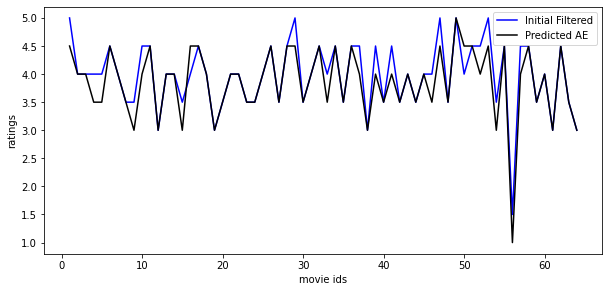

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(211)
line1, = plt.plot(range(1,65), df.iloc[6], 'b')
line2, = plt.plot(range(1,65), ans_df.iloc[3], 'k')
plt.ylabel('ratings')
plt.xlabel('movie ids')
plt.legend([line1, line2], ['Initial Filtered', 'Predicted AE'])

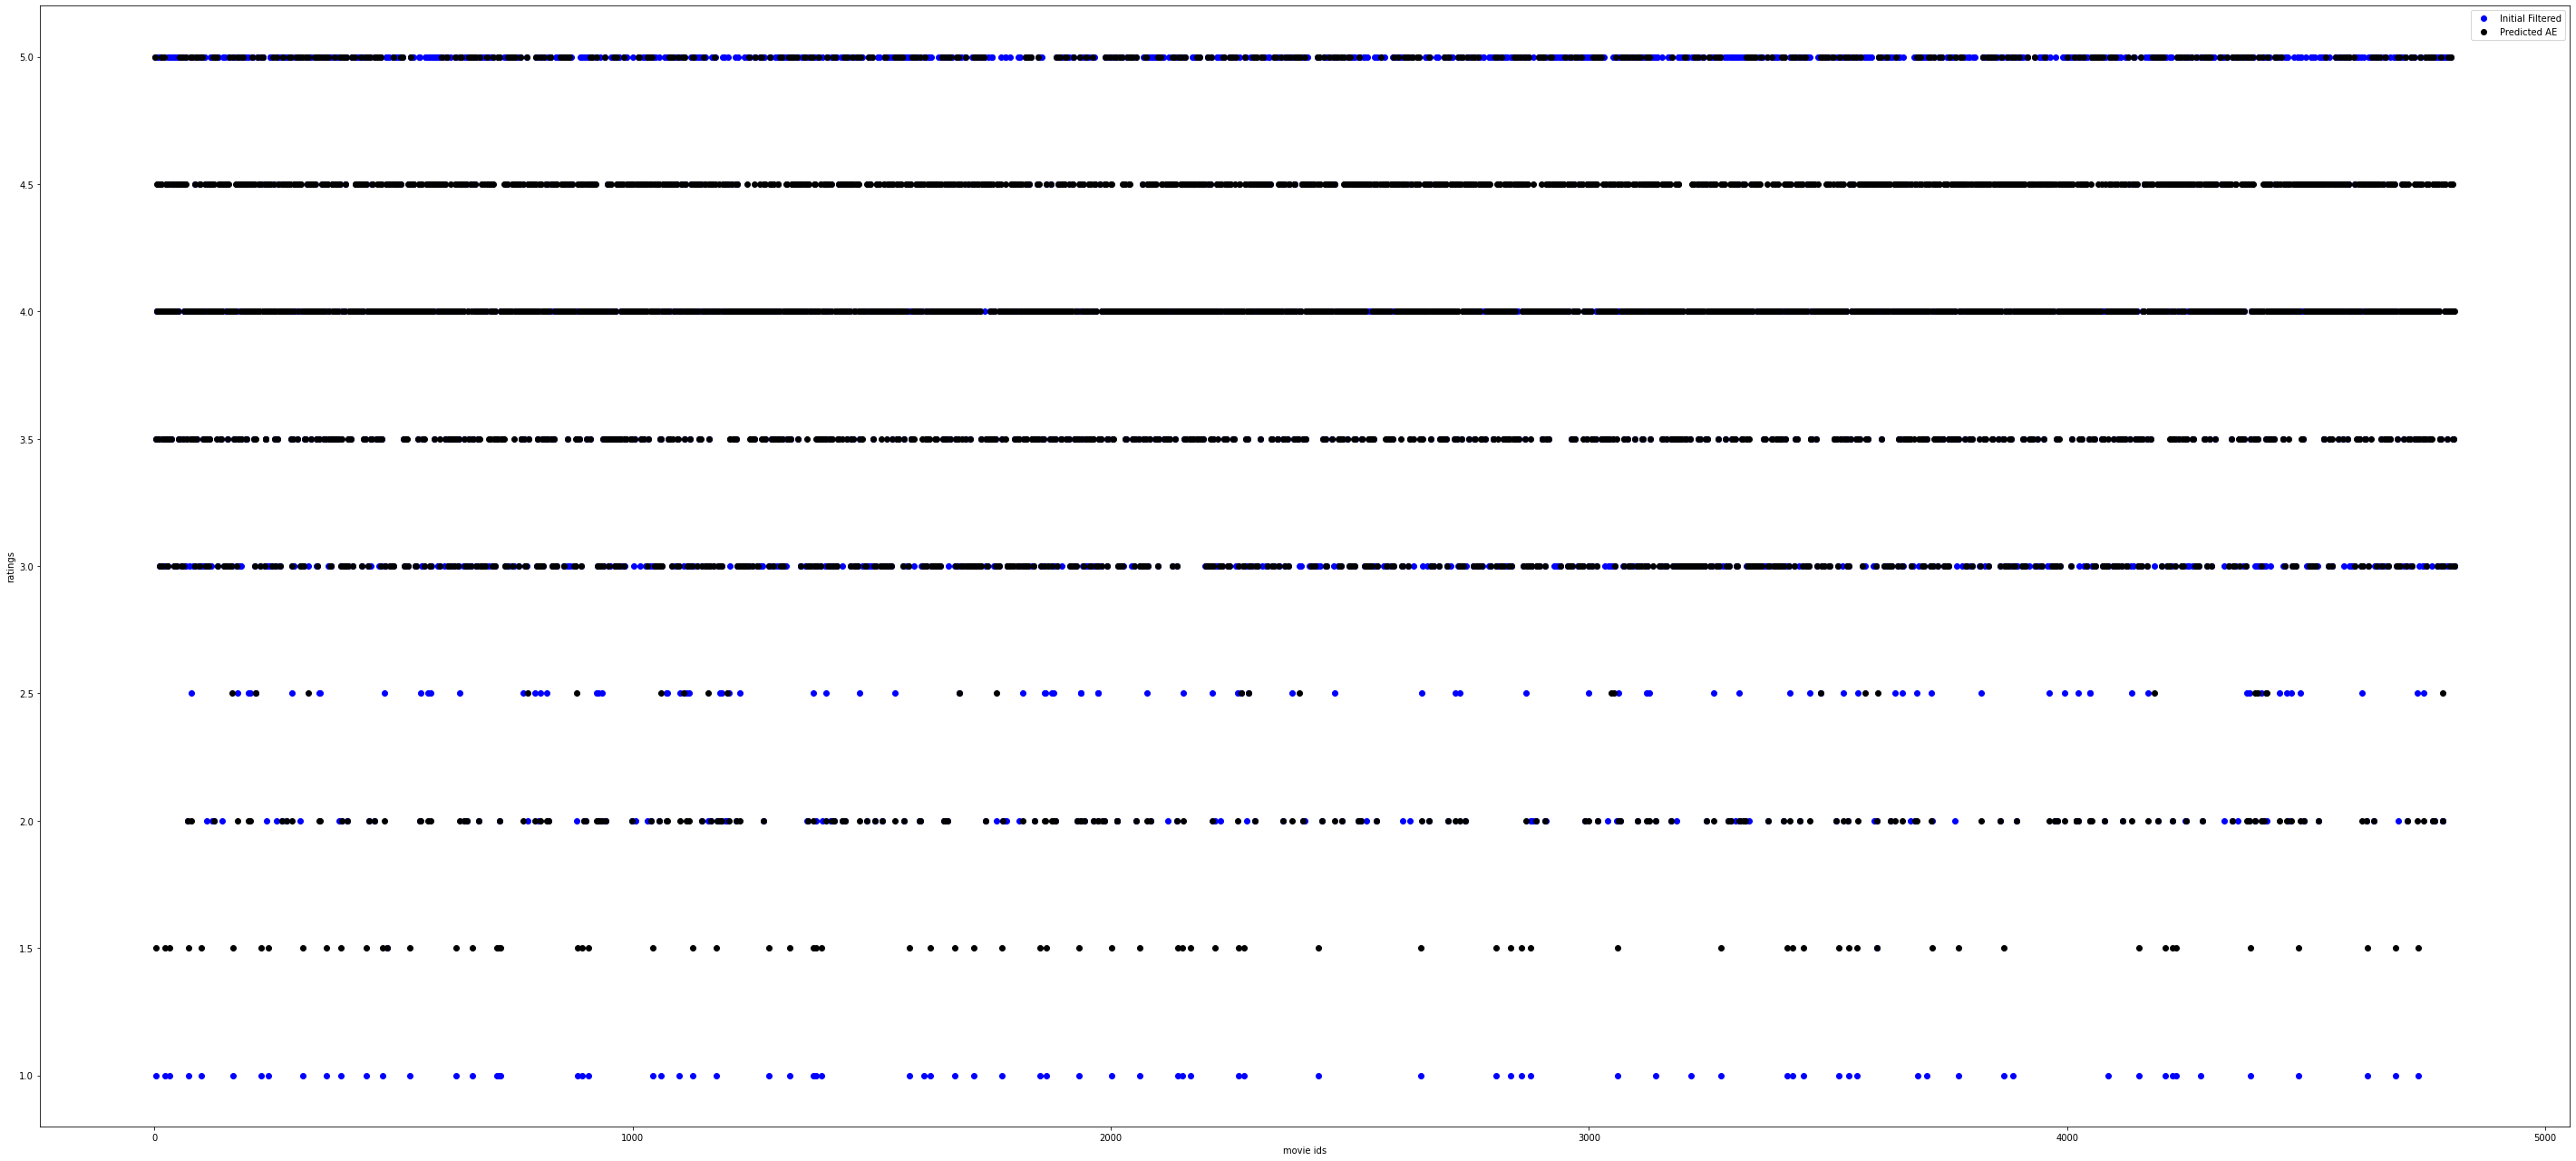

In [ ]:
plt.figure(figsize=(50,50))
plt.subplot(212)
line1, = plt.plot(range(1,4812), df[1].tolist(), 'bo')
line2, = plt.plot(range(1,4812), ans_df[0].tolist(), 'ko')
plt.ylabel('ratings')
plt.xlabel('movie ids')
plt.legend([line1, line2], ['Initial Filtered', 'Predicted AE'])

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p tensorflow

Author: Sparsh A.

Last updated: 2021-12-09 06:23:40

tensorflow: 2.7.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pandas    : 1.1.5
IPython   : 5.5.0
numpy     : 1.19.5
matplotlib: 3.2.2



---

**END**